<a href="https://colab.research.google.com/github/MekdiYilma/HumanitarianCrisisPrediction/blob/main/notebooks/ARIMA_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [5]:
%%bigquery --project asana-bq yemen_df
SELECT SQLDATE, Actor1Name, Actor2Name, QuadClass, GoldsteinScale, NumArticles, AvgTone, EventCode
FROM `gdelt-bq.gdeltv2.events` 
WHERE ActionGeo_CountryCode = 'YM'
ORDER BY SQLDATE DESC 
LIMIT 20000

In [7]:
yemen_df

,SQLDATE,Actor1Name,Actor2Name,QuadClass,GoldsteinScale,NumArticles,AvgTone,EventCode
0,20210713,ISLAMIC,MUSLIM,3,-4.0,8,-1.594331,120
1,20210713,DETAINEE,None,1,2.8,10,-10.862620,043
2,20210713,None,YEMEN,4,-10.0,5,-2.319902,190
3,20210713,MERCENARIES,YEMEN,1,-0.4,1,-3.690037,012
4,20210713,YEMEN,None,4,-10.0,1,-0.316866,190
...,...,...,...,...,...,...,...,...
19995,20210505,ARMENIA,TURKEY,2,7.4,2,-3.642987,062
19996,20210505,IRAN,ABU DHABI,1,1.9,2,-0.347222,042
19997,20210505,UNITED NATIONS,MILITIA,4,-10.0,2,-4.940375,190
19998,20210505,ABU DHABI,IRAN,1,2.8,2,-0.347222,043


In [8]:
humanitarian_crisis_events = ['0233', '0243', '0333', '0343', '0243', '073', '074', '0833', '0861', '0863',
                              '092', '094', '103', '1033', '1043', '1122', '1124', '1233', '137', '138', 
                              '1382', '1383', '1384', '1385', '1413', '1423', '1451', '1452', '1453', '1454', 
                              '175', '18', '180', '181', '182', '1821', '1822', '1823', '183', '1831', '1832', 
                              '1833', '184']
yemen_df['IsHumanitarianCrisis'] = yemen_df.EventCode.isin(humanitarian_crisis_events)

In [9]:
yemen_df.SQLDATE = pd.to_datetime(yemen_df.SQLDATE, format='%Y%m%d', errors='ignore')
yemen_df = yemen_df.set_index('SQLDATE')

In [10]:
yemen_df_grouped = yemen_df['IsHumanitarianCrisis'].groupby(pd.Grouper(freq='d')).agg(['sum','count','mean'])
yemen_df_grouped

,sum,count,mean
SQLDATE,,,
2021-05-05,2,76,0.026316
2021-05-06,8,430,0.018605
2021-05-07,18,476,0.037815
2021-05-08,19,334,0.056886
2021-05-09,18,308,0.058442
...,...,...,...
2021-07-09,10,224,0.044643
2021-07-10,9,214,0.042056
2021-07-11,4,181,0.022099


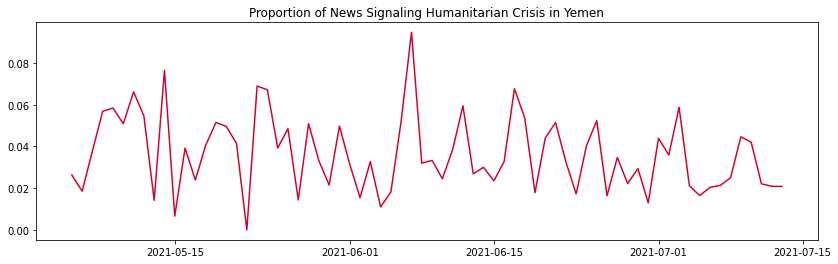

In [11]:
plt.figure(figsize=(14, 4))
plt.title('Proportion of News Signaling Humanitarian Crisis in Yemen')
plt.plot(yemen_df_grouped['mean'], color='#D2042D') ;



In [12]:
rollmean = yemen_df_grouped['mean'].rolling(window=7).mean()
rollstd = yemen_df_grouped['mean'].rolling(window=7).std()

Text(0.5, 1.0, 'Stationarity Check')

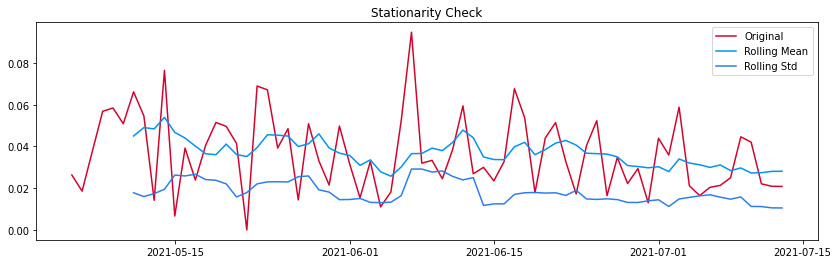

In [13]:
plt.figure(figsize=(14, 4))
original = plt.plot(yemen_df_grouped['mean'], color = '#D2042D', label = 'Original')
mean = plt.plot(rollmean, color = '#0092F4', label = 'Rolling Mean')
std = plt.plot(rollstd, color = '#2D7DF1', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Stationarity Check')


In [14]:
from statsmodels.tsa.stattools import adfuller

print('Results of Dickey-Fullter Test:')
dftest = adfuller(yemen_df_grouped['mean'], autolag = 'AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '# Lags Used', '# of Obs Used'])
for k, v in dftest[4].items():
  dfoutput[f'Critiical Values: {k}'] = v

dfoutput

Results of Dickey-Fullter Test:


Test Statistic          -6.069079e+00
p-value                  1.162563e-07
# Lags Used              1.000000e+00
# of Obs Used            6.800000e+01
Critiical Values: 1%    -3.530399e+00
Critiical Values: 5%    -2.905087e+00
Critiical Values: 10%   -2.590001e+00
dtype: float64

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

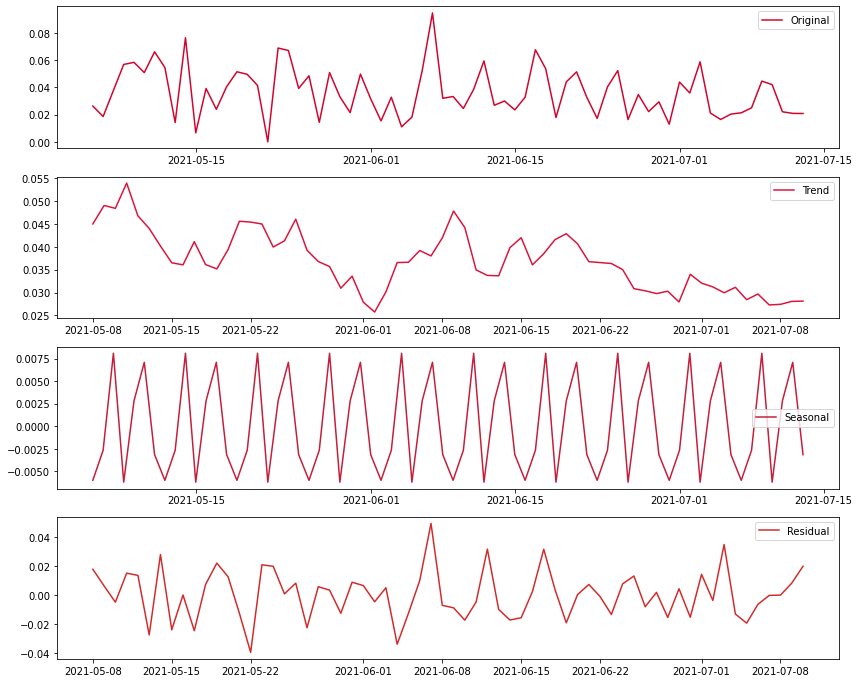

In [16]:
decomposition = seasonal_decompose(yemen_df_grouped['mean'])
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(14,12))
plt.subplot(411)
plt.plot(yemen_df_grouped['mean'], label = 'Original', color = '#D2042D')
plt.legend()
plt.subplot(412)
plt.plot(trend, label = 'Trend', color = '#DC143C')
plt.legend()
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal', color = '#C41E3A')
plt.legend()
plt.subplot(414)
plt.plot(residual, label = 'Residual', color = '#D22B2B')
plt.legend()

In [17]:
def test_stationarity(df, window=7, colors=['#D2042D', '#79B1E0', '#0092F4']):

  print('Results of Dickey-Fullter Test on Residual:')
  dftest = adfuller(df, autolag = 'AIC')

  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '# Lags Used', '# of Obs Used'])
  for k, v in dftest[4].items():
    dfoutput[f'Critiical Values: {k}'] = v

  print(dfoutput)

  rollmean = decomposed_residual.rolling(window=window).mean()
  rollstd = decomposed_residual.rolling(window=window).std()

  plt.figure(figsize=(14, 4))
  original = plt.plot(decomposed_residual, color = colors[0], label = 'Residual')
  mean = plt.plot(rollmean, color = colors[1], label = 'Rolling Mean')
  std = plt.plot(rollstd, color = colors[2], label = 'Rolling Std')
  plt.legend(loc='best')
  plt.title('Stationarity Check')
  plt.show()


Results of Dickey-Fullter Test on Residual:
Test Statistic          -6.399077e+00
p-value                  2.016462e-08
# Lags Used              6.000000e+00
# of Obs Used            5.700000e+01
Critiical Values: 1%    -3.550670e+00
Critiical Values: 5%    -2.913766e+00
Critiical Values: 10%   -2.594624e+00
dtype: float64


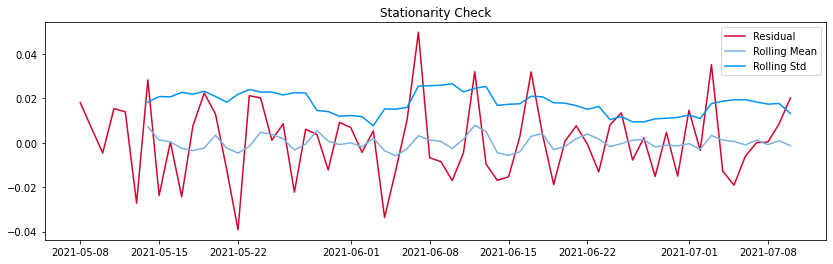

In [18]:
decomposed_residual = residual.dropna()

test_stationarity(decomposed_residual, window=7,  colors=['#D2042D', '#79B1E0', '#0092F4'])



Results of Dickey-Fullter Test on Residual:
Test Statistic          -6.351858e+00
p-value                  2.599115e-08
# Lags Used              5.000000e+00
# of Obs Used            6.300000e+01
Critiical Values: 1%    -3.538695e+00
Critiical Values: 5%    -2.908645e+00
Critiical Values: 10%   -2.591897e+00
dtype: float64


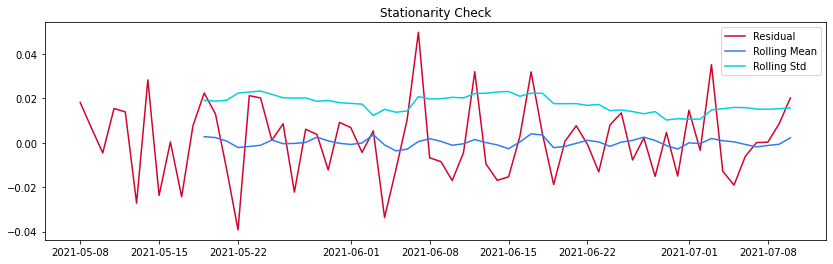

In [19]:
first_diff = yemen_df_grouped['mean'] - yemen_df_grouped['mean'].shift(1)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 12, colors=['#D2042D', '#2D7DF1', '#00D0E4'])

Results of Dickey-Fullter Test on Residual:
Test Statistic          -6.069079e+00
p-value                  1.162563e-07
# Lags Used              1.000000e+00
# of Obs Used            6.800000e+01
Critiical Values: 1%    -3.530399e+00
Critiical Values: 5%    -2.905087e+00
Critiical Values: 10%   -2.590001e+00
dtype: float64


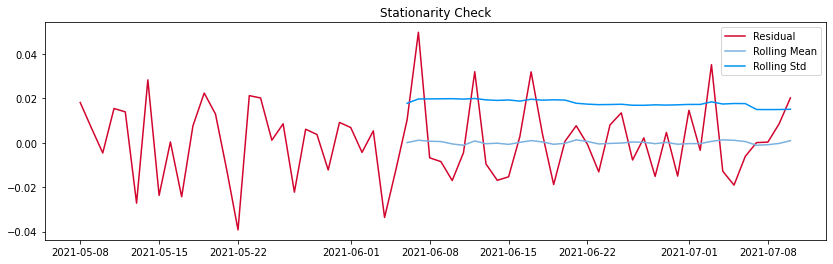

In [20]:
test_stationarity(yemen_df_grouped['mean'], window=30,  colors=['#D2042D', '#79B1E0', '#0092F4'])


In [21]:
from scipy import stats

(mu, sigma) = stats.norm.fit(decomposed_residual)

Text(0.5, 1.0, 'Residual distribution')

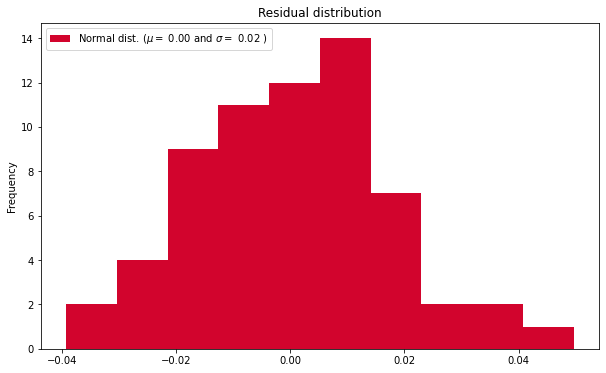

In [22]:
plt.figure(figsize=(10,6))
plt.hist(decomposed_residual, color='#D2042D')
plt.legend([f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


''

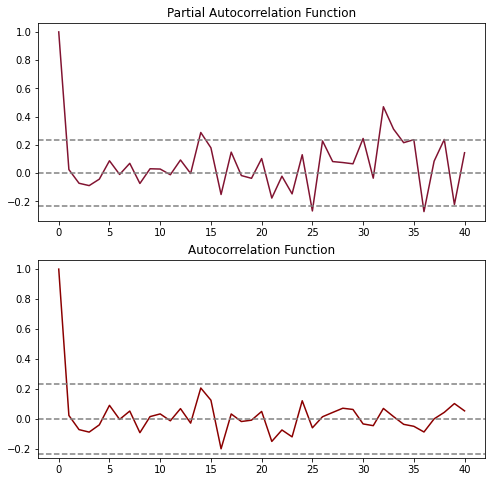

In [34]:
from statsmodels.tsa.stattools import acf, pacf

lag_pacf = pacf(yemen_df_grouped['mean'], method='ols' )
lag_acf = acf(yemen_df_grouped['mean'])


plt.figure(figsize=(8,8))

plt.subplot(211)
plt.plot(lag_pacf, color='#811331')
plt.axhline(y=0, linestyle='--', color='grey')
plt.axhline(y=-1.96/np.sqrt(len(yemen_df_grouped['mean'])), linestyle='--', color='grey')
plt.axhline(y=1.96/np.sqrt(len(yemen_df_grouped['mean'])), linestyle='--', color='grey')
plt.title('Partial Autocorrelation Function')


plt.subplot(212)
plt.plot(lag_acf, color='#8B0000')
plt.axhline(y=0, linestyle='--', color='grey')
plt.axhline(y=-1.96/np.sqrt(len(yemen_df_grouped['mean'])), linestyle='--', color='grey')
plt.axhline(y=1.96/np.sqrt(len(yemen_df_grouped['mean'])), linestyle='--', color='grey')
plt.title('Autocorrelation Function')
;

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


''

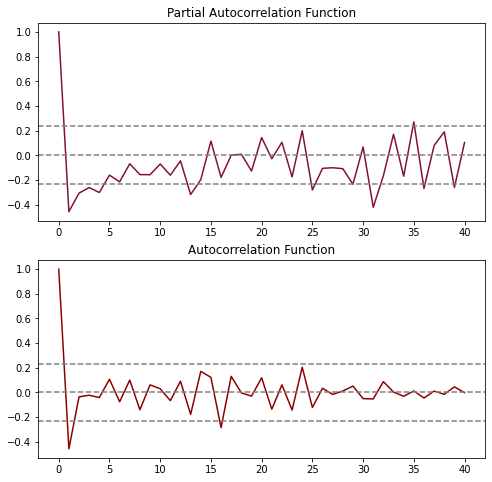

In [35]:
lag_pacf = pacf(first_diff, method='ols' )
lag_acf = acf(first_diff)


plt.figure(figsize=(8,8))
plt.subplot(211)
plt.plot(lag_pacf, color='#811331')
plt.axhline(y=0, linestyle='--', color='grey')
plt.axhline(y=-1.96/np.sqrt(len(yemen_df_grouped['mean'])), linestyle='--', color='grey')
plt.axhline(y=1.96/np.sqrt(len(yemen_df_grouped['mean'])), linestyle='--', color='grey')
plt.title('Partial Autocorrelation Function')


plt.subplot(212)
plt.plot(lag_acf, color='#8B0000')
plt.axhline(y=0, linestyle='--', color='grey')
plt.axhline(y=-1.96/np.sqrt(len(yemen_df_grouped['mean'])), linestyle='--', color='grey')
plt.axhline(y=1.96/np.sqrt(len(yemen_df_grouped['mean'])), linestyle='--', color='grey')
plt.title('Autocorrelation Function')
;

In [75]:
from 	statsmodels.tsa.arima_model import ARIMA

model = ARIMA(yemen_df_grouped['mean'], order=(4,1,1))
model = model.fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.mean   No. Observations:                   69
Model:                 ARIMA(4, 1, 1)   Log Likelihood                 179.469
Method:                       css-mle   S.D. of innovations              0.017
Date:                Tue, 13 Jul 2021   AIC                           -344.939
Time:                        21:22:54   BIC                           -329.300
Sample:                    05-06-2021   HQIC                          -338.734
                         - 07-13-2021                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0002   6.89e-05     -3.211      0.002      -0.000   -8.62e-05
ar.L1.D.mean    -0.0777      0.121     -0.644      0.522      -0.314       0.159
ar.L2.D.mean    -0.1635      0.120     -1.358      0.179      -0.399       0.072
ar.L3.D.mean    -0.1743      0.120     -1.457      0.150      -0.409       0.060
ar.L4.D.mean    -0.1309      0.120     -1.087      0.281      -0.367       0.105
ma.L1.D.mean    -0.9993      0.043    -23.407      0.000      -1.083      -0.916
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.7749           -1.2378j            1.4604           -0.1610
AR.2            0.7749           +1.2378j            1.4604            0.1610
AR.3           -1.4406           -1.2275j            1.8926           -0.3877
AR.4           -1.4406           +1.2275j            1.8926            0.3877
MA.1            1.0007           +0.0000j            1.0007            0.0000
-----------------------------------------------------------------------------
"""

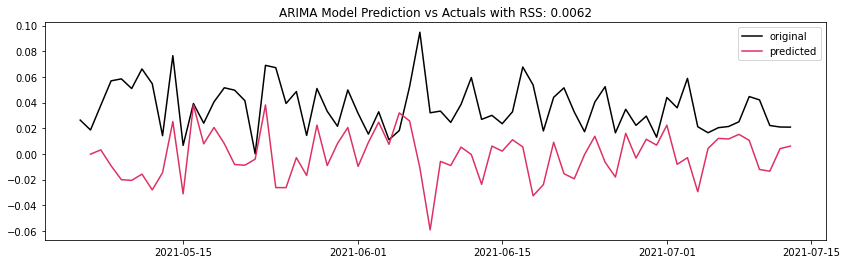

In [99]:
plt.figure(figsize=(14,4))
plt.plot(yemen_df_grouped['mean'], color='black', label='original')
plt.plot(model.fittedvalues, color='#DE3163', label='predicted')
plt.title(f'ARIMA Model Prediction vs Actuals with RSS: {(sum(model.fittedvalues - first_diff))**2:.4f}')
plt.legend()


In [90]:
from sklearn.metrics import mean_squared_error

print(f'RMSE: {np.sqrt(mean_squared_error(model.fittedvalues, first_diff)):.4f}')
len(yemen_df_grouped)

RMSE: 0.0180


70

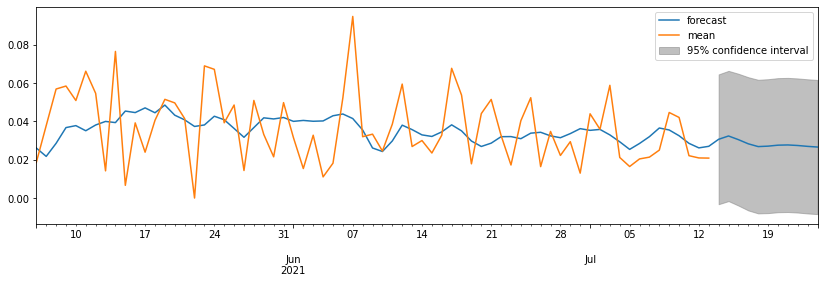

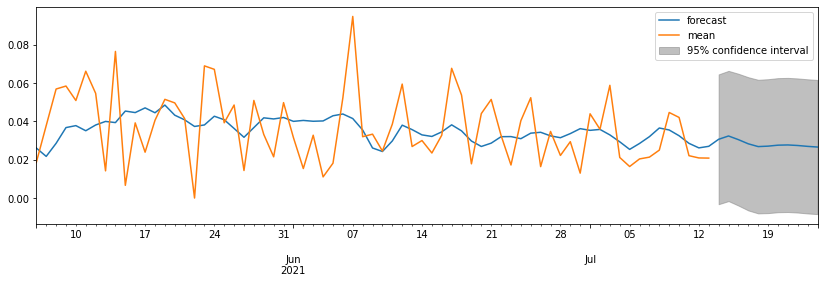

In [97]:
fig, ax = plt.subplots(figsize=(14,4))
model.plot_predict(start=1, end=80, ax=ax,)


In [29]:
end=len(yemen_df_grouped['mean'])
pred = model.predict(start=1, end=end+10)
pred

2021-05-06   -0.000220
2021-05-07    0.003122
2021-05-08   -0.009248
2021-05-09   -0.020241
2021-05-10   -0.021579
                ...   
2021-07-20   -0.000016
2021-07-21   -0.000046
2021-07-22   -0.000492
2021-07-23   -0.000419
2021-07-24   -0.000130
Freq: D, Length: 80, dtype: float64

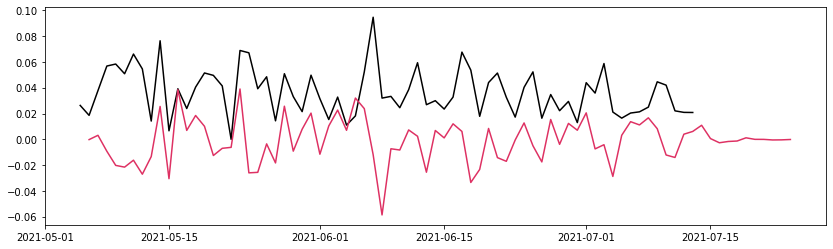

In [98]:
plt.figure(figsize=(14,4))
plt.plot(yemen_df_grouped['mean'], color='black')
plt.plot(pred, color='#DE3163')

In [112]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('{}(t-{})'.format(col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('{}(t)'.format(col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('{}(t+{})'.format(col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
